# Hold-out

In [256]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz, process
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

sns.set()

In [257]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_price = pd.read_csv("sample_submission.csv")

In [258]:
test_merge = pd.merge(test, test_price, on='carID', how='left')
test_merge.head()

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,price
0,89856,Hyundai,I30,2022.878006,Automatic,30700.000000,petrol,205.0,41.5,1.6,61.0,3.0,0.0,851000
1,106581,VW,Tiguan,2017.000000,Semi-Auto,-48190.655673,Petrol,150.0,38.2,2.0,60.0,2.0,0.0,514000
2,80886,BMW,2 Series,2016.000000,Automatic,36792.000000,Petrol,125.0,51.4,1.5,94.0,2.0,0.0,323000
3,100174,Opel,Grandland X,2019.000000,Manual,5533.000000,Petrol,145.0,44.1,1.2,77.0,1.0,0.0,921000
4,81376,BMW,1 Series,2019.000000,Semi-Auto,9058.000000,Diesel,150.0,51.4,2.0,45.0,4.0,0.0,620000


In [259]:
X_train_val = train.drop('price', axis=1) 
y_train_val = train['price']
X_test = test_merge.drop('price', axis=1)
y_test = test_merge['price']

In [260]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val, 
    test_size=0.25, 
    random_state=15
)

In [261]:
print('train:{}% | validation:{}%'.format(round(len(y_train)/len(y_train_val),2),
                                                     round(len(y_val)/len(y_train_val),2),))

train:0.75% | validation:0.25%


In [262]:
X_features = [X_train, X_val,X_test]

## Data Quality check

In [263]:
X_train.head(3)

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
11382,5314,AUDI,A1,2015.0,Manual,29119.0,Petrol,30.0,56.5,1.4,97.0,3.000000,0.0
50430,74187,VW,Golf,2016.0,Manua,20820.0,Petrol,200.0,39.8,2.0,62.0,1.000000,0.0
42482,19970,Ford,Focus,2019.0,Manual,1038.0,Petrol,145.0,50.4,1.5,77.0,-2.340306,0.0


In [264]:
X_train.duplicated("carID").sum()

0

No carID duplicated, so we can put as index.

In [265]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56979 entries, 11382 to 7624
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           56979 non-null  int64  
 1   Brand           55881 non-null  object 
 2   model           55833 non-null  object 
 3   year            55859 non-null  float64
 4   transmission    55831 non-null  object 
 5   mileage         55856 non-null  float64
 6   fuelType        55841 non-null  object 
 7   tax             51098 non-null  float64
 8   mpg             51079 non-null  float64
 9   engineSize      55833 non-null  float64
 10  paintQuality%   55812 non-null  float64
 11  previousOwners  55784 non-null  float64
 12  hasDamage       55842 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 6.1+ MB


In [266]:
metric_features = ['year', 'mileage','tax','mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
non_metric_features = X_train.columns.drop(metric_features).to_list()
non_metric_features.remove("carID")


We can conclude that we have many strange values in all columns and some Dtypes are wrong (year;previousOwners).

In [267]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
carID,56979.0,38028.260324,21937.790672,0.000000,19037.5,38024.0,57011.5,75972.000000
year,55859.0,2017.099208,2.192280,1996.000000,2016.0,2017.0,2019.0,2024.121759
mileage,55856.0,22971.941864,22134.568422,-58540.574478,7449.5,17288.0,32380.0,323000.000000
tax,51098.0,119.921088,65.299578,-91.121630,125.0,145.0,145.0,580.000000
mpg,51079.0,55.164644,16.439379,-43.421768,46.3,54.3,62.8,470.800000
engineSize,55833.0,1.658536,0.570381,-0.103493,1.2,1.6,2.0,6.200000
paintQuality%,55812.0,64.626594,21.026829,1.638913,47.0,65.0,82.0,125.594308
previousOwners,55784.0,1.998415,1.473250,-2.345650,1.0,2.0,3.0,6.258371
hasDamage,55842.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


##### Here we can detect many strange values as:
    2024.121759 in the year column;
    -58540.574478 in the mileage column;
    -91.121630 in the tax column;
    -43.421768 in the mpg column;
    -0.103493 in the engineSize column;
    125.594308 in the paintQuality% column;
    -2.345650 in the previousOwners column;
    just zeros in the hasDamage column.

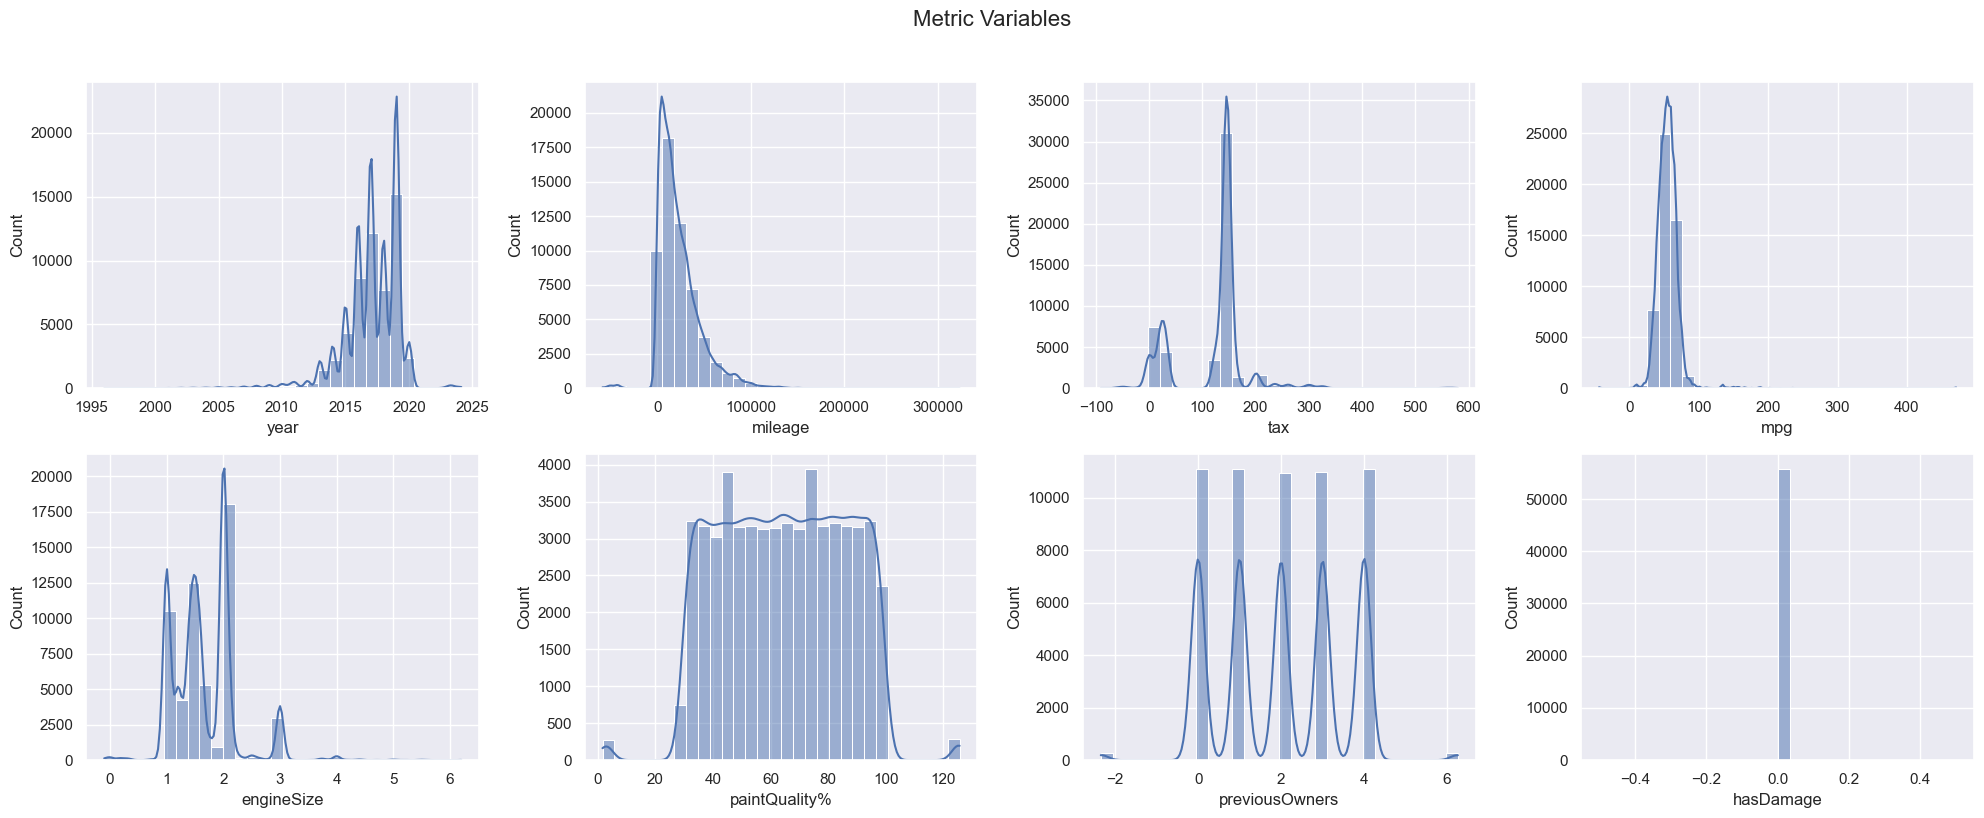

In [268]:
sp_rows = 2
sp_cols = 4

# Prepare figure and axes
fig, axes = plt.subplots(sp_rows, sp_cols, figsize=(20, 8), tight_layout=True)

# Plot data with seaborn
features = [f for f in metric_features]

for ax, feat in zip(axes.flatten(), features):
    sns.histplot(X_train[feat], bins=30, kde=True, ax=ax)

# Add a centered title to the figure
title = "Metric Variables"
fig.suptitle(title, fontsize=16, y=1.02)

plt.show()


From the histograms, I can observe that most of the metric variables are right-skewed and contain several outliers. Because of this non-normal distribution, replacing missing values (NaNs) with the median is more appropriate than using the mean, as the median is less affected by extreme values and better represents the central tendency of skewed data.

In [269]:
print(X_train.isna().sum())

carID                0
Brand             1098
model             1146
year              1120
transmission      1148
mileage           1123
fuelType          1138
tax               5881
mpg               5900
engineSize        1146
paintQuality%     1167
previousOwners    1195
hasDamage         1137
dtype: int64


In [270]:
X_train.hasDamage.value_counts()

hasDamage
0.0    55842
Name: count, dtype: int64

By looking at this result, we can conclude that the stand only sells cars that have no damage at all

# Pre Processing 

### Metric variables

In [271]:
def strange_values_to_nan(f,column,limit):
    strange_values = f[column] < limit
    f.loc[strange_values, column] = np.nan 
    print(f"Found {strange_values.sum()} strange values in {column}.")

In [272]:
def pre_processing_metric(metric):
    for f in metric:
        
        #setting carID as index
        f.set_index("carID", inplace=True)

        #fixing the types
        f["year"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in f["year"]]
        f["year"] = f["year"].astype("Int64")
        f["previousOwners"]=[int(i) if isinstance(i, float) and not pd.isna(i) else i for i in f["previousOwners"]]
        f["previousOwners"] = f["previousOwners"].astype("Int64")

        #converting strange values to nan
        strange_values_to_nan(f,"mileage",0)
        strange_values_to_nan(f,"tax",0)
        strange_values_to_nan(f,"mpg",10)
        strange_values_to_nan(f,"engineSize",1)
        strange_values_to_nan(f,"previousOwners",0)
        f.loc[f["paintQuality%"] > 100, "paintQuality%"] = np.nan 

        #deleting column hasDamage because it has the same value in all rows
        del f["hasDamage"]

        #filling nans with the median
        for var in metric_features:
            median = f[var].median()
            f[var] = f[var].fillna(median)

In [273]:
metric_features.remove("hasDamage") #removing hasDamage from metric_features list, because we deleted this column.

In [274]:
pre_processing_metric(X_features)

Found 286 strange values in mileage.
Found 282 strange values in tax.
Found 108 strange values in mpg.
Found 437 strange values in engineSize.
Found 278 strange values in previousOwners.
Found 83 strange values in mileage.
Found 96 strange values in tax.
Found 43 strange values in mpg.
Found 137 strange values in engineSize.
Found 93 strange values in previousOwners.
Found 170 strange values in mileage.
Found 161 strange values in tax.
Found 74 strange values in mpg.
Found 245 strange values in engineSize.
Found 168 strange values in previousOwners.


### Non metric variables


In [275]:
def build_valid_dic(column, valid_list, cuttoff):
    #first, clean de column and the valid list
    unique_column_values = [str(v).strip().lower() for v in column.dropna().unique()]
    #secound, creat the dic with the valid values with empyt similar words
    result = {valid_word: [] for valid_word in valid_list}

    for valid in valid_list:
        valid_lower = valid.lower()
        fuzzy_matched_values = process.extract(
            valid_lower, #the check valeu
            unique_column_values, #the list that we are going to use to check
            scorer = fuzz.token_sort_ratio,
            score_cutoff = cuttoff
        )
        for match_value, score, _ in fuzzy_matched_values:
            if match_value != valid_lower:
                result[valid].append(match_value)

    return result


def replace_invalid_values(column, valid_dic):
    corrected = []
    for val in column:
        if pd.isna(val):
            corrected.append(val)
            continue
        valeu_cleaned = str(val).strip().lower()
        found = False
        for key in valid_dic:
            if valeu_cleaned == key.lower():
                corrected.append(key)
                found = True
                break
        if not found:
            for valid_key, variations in valid_dic.items():
                if valeu_cleaned in [v.lower() for v in variations]:
                    corrected.append(valid_key)
                    found = True
                    break
        if not found:
            corrected.append(val)

    return corrected
def fill_nans_categorical(data, columns):
    for col in columns:
        data[col] =data[col].fillna("Unknown")
    return data


def dic_brand_modles(brands, models, valid_brands):
    result = {brand: [] for brand in valid_brands}
    for brand, model in zip(brands,models):
        if pd.isna(brand) or pd.isna(model):
            continue
        model_clean = str(model).strip().lower()
        if model_clean not in result[brand]:
            result[brand].append(model_clean)

    return result

def pre_processing_non_metric(dic_col_valid, data):
    for i in range(1,4):
        for key,values in dic_col_valid.items():
            valid_dic = build_valid_dic(data[key],values, cuttoff= 50)
            data[key] = replace_invalid_values(data[key], valid_dic)
            if i == 3:
                print(data[key].value_counts())
        

In [276]:
valid_brands_list = ["Ford", "Mercedes", "VW", "Opel", "BMW", "Audi", "Toyota","Skoda", "Hyundai", "Unknown"]
valid_transmition_list = ["Manual", "Semi-Auto", "Automatic", "Other", "Unknown"]
valid_fueltype_list = ["Petrol" ,"Diesel", "Hybrid" , "Other", "Electric", "Unknown"]
cols_change_dic = {"Brand" : valid_brands_list,
                   "transmission" : valid_transmition_list,
                   "fuelType" : valid_fueltype_list
                   }

In [277]:
for f in X_features:
    fill_nans_categorical(f, non_metric_features)
    pre_processing_non_metric(cols_change_dic, f)

Brand
Ford        12032
Mercedes     8744
VW           7836
Opel         6978
BMW          5520
Audi         5494
Toyota       3499
Skoda        3271
Hyundai      2507
Unknown      1098
Name: count, dtype: int64
transmission
Manual       31165
Semi-Auto    12683
Automatic    11441
Unknown       1687
Other            3
Name: count, dtype: int64
fuelType
Petrol      30879
Diesel      23132
Hybrid       1689
Unknown      1138
Other         124
Electric       17
Name: count, dtype: int64
Brand
Ford        4033
Mercedes    2930
VW          2549
Opel        2374
BMW         1872
Audi        1831
Toyota      1123
Skoda       1030
Hyundai      829
Unknown      423
Name: count, dtype: int64
transmission
Manual       10462
Semi-Auto     4189
Automatic     3770
Unknown        571
Other            2
Name: count, dtype: int64
fuelType
Petrol      10284
Diesel       7753
Hybrid        536
Unknown       373
Other          43
Electric        5
Name: count, dtype: int64
Brand
Ford        6891
Mercedes 

In [278]:
dic_brands = dic_brand_modles(X_test["Brand"],X_test["model"],valid_brands_list)
for key, value in dic_brands.items():
    print(f"{key} have this models:\n {value}")

Ford have this models:
 ['fiesta', 'focus', 'ecosport', 'kuga', 'grand c-max', 'ka+', 'unknown', 'ka', 'focu', 'galaxy', 'mondeo', 'fiest', 'c-max', 'fusion', 'b-max', 'puma', 's-max', 'edge', 'tourneo custom', 'mustang', 'b-ma', 'monde', 's-ma', 'kug', 'ecospor', 'grand tourneo connect', 'octavi', 'tourneo custo', 'tourneo connect', 'edg', 'fabia', 'c-ma', 'galax', 'kodia', 'grand tourneo connec', 'transit tourneo', 'grand c-ma', 'pum', 'k']
Mercedes have this models:
 ['b class', 'c class', 'm clas', 'e class', 'a class', 'x-class', 'v class', 'sl class', 'gla class', 'cls class', 'glc class', 'cl class', 's class', 'c clas', 'gl class', 'gle class', 'unknown', 'cla class', 'g clas', 'slk', 'm class', 'glb class', 'gls class', 'cl clas', 'e clas', 'x-clas', '180', 'glc clas', 'g class', 'a clas', 'r class', 'b clas', 'gla clas', 'sl clas', 'clk', 'clc class', 's clas', 'cla clas', 'gl clas', 'sl', 'gls clas']
VW have this models:
 ['tiguan', 'up', 'golf', 'passat', 'caravelle', 'polo